In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sns.set_theme(style="whitegrid", palette="crest")


In [10]:
data_path = "onlinefoods.csv"

df = pd.read_csv(data_path).dropna(axis=1, how='all')
df.columns = df.columns.str.strip().str.replace(' ', '_')
for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype(str).str.strip()

print(f"Файл загружен: {data_path}. Размер: {df.shape[0]} строк x {df.shape[1]} столбцов")


Файл загружен: onlinefoods.csv. Размер: 388 строк x 13 столбцов


In [11]:
print("Форма датафрейма:", df.shape)

print("\nПервые 5 строк:")
display(df.head())

print("\nЧисловые признаки:")
display(df.describe(include='number').T)

print("\nКатегориальные признаки:")
display(df.describe(include='object').T)

print("\nИнформация о столбцах:")
df.info()


Форма датафрейма: (388, 13)

Первые 5 строк:


,Age,Gender,Marital_Status,Occupation,Monthly_Income,Educational_Qualifications,Family_size,latitude,longitude,Pin_code,Output,Feedback,Unnamed:_12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes



Числовые признаки:


,count,mean,std,min,25%,50%,75%,max
Age,388.0,24.628866,2.975593,18.0000,23.000000,24.0000,26.000000,33.0000
Family_size,388.0,3.280928,1.351025,1.0000,2.000000,3.0000,4.000000,6.0000
latitude,388.0,12.972058,0.044489,12.8652,12.936900,12.9770,12.997025,13.1020
longitude,388.0,77.600160,0.051354,77.4842,77.565275,77.5921,77.630900,77.7582
Pin_code,388.0,560040.113402,31.399609,560001.0000,560010.750000,560033.5000,560068.000000,560109.0000



Категориальные признаки:


,count,unique,top,freq
Gender,388,2,Male,222
Marital_Status,388,3,Single,268
Occupation,388,4,Student,207
Monthly_Income,388,5,No Income,187
Educational_Qualifications,388,5,Graduate,177
Output,388,2,Yes,301
Feedback,388,2,Positive,317
Unnamed:_12,388,2,Yes,301



Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital_Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly_Income              388 non-null    object 
 5   Educational_Qualifications  388 non-null    object 
 6   Family_size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin_code                    388 non-null    int64  
 10  Output                      388 non-null    object 
 11  Feedback                    388 non-null    object 
 12  Unnamed:_12                 388 non-null    object 
dtypes: float64(

In [12]:
target_col = 'Feedback'

balance = df[target_col].value_counts().to_frame(name='count')
balance['share'] = (balance['count'] / len(df)).round(3)
print("Распределение целевого признака Feedback:")
display(balance)


Распределение целевого признака Feedback:


,count,share
Feedback,,
Positive,317,0.817
Negative,71,0.183


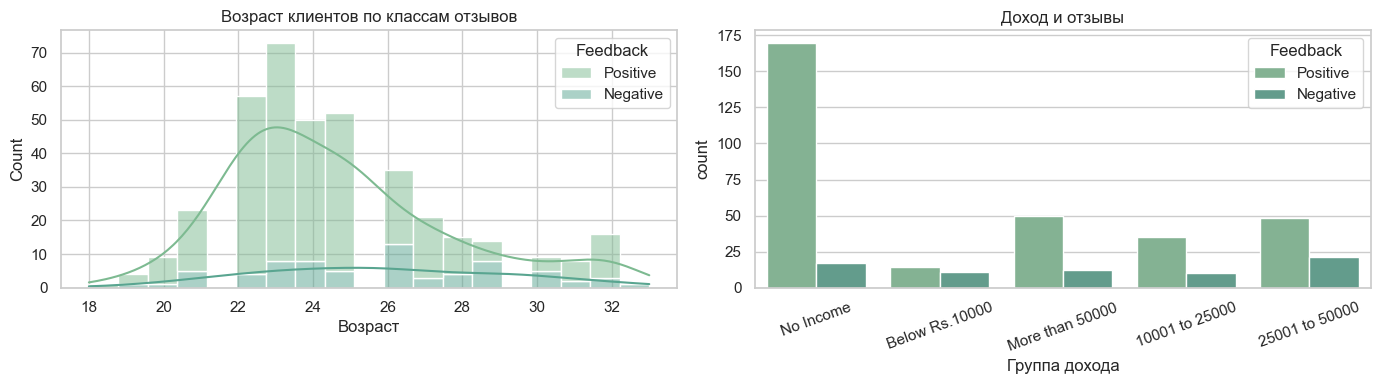

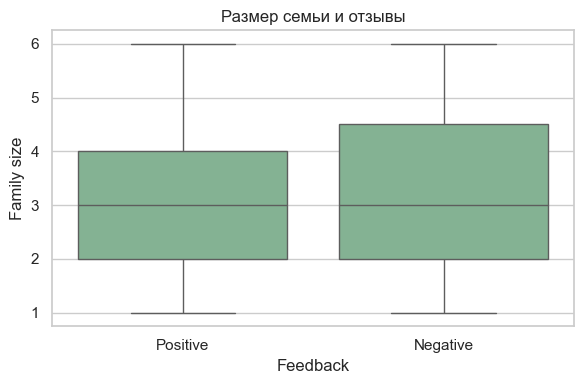

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(data=df, x='Age', hue=target_col, kde=True, multiple='stack', ax=axes[0])
axes[0].set_title('Возраст клиентов по классам отзывов')
axes[0].set_xlabel('Возраст')

sns.countplot(data=df, x='Monthly_Income', hue=target_col, ax=axes[1])
axes[1].set_title('Доход и отзывы')
axes[1].tick_params(axis='x', rotation=20)
axes[1].set_xlabel('Группа дохода')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x=target_col, y='Family_size')
plt.title('Размер семьи и отзывы')
plt.xlabel('Feedback')
plt.ylabel('Family size')
plt.tight_layout()
plt.show()


In [14]:
target_numeric = df[target_col].map({'Positive': 1, 'Negative': 0})
numeric_for_corr = [col for col in ['Age', 'Family_size', 'latitude', 'longitude'] if col in df.columns]

corr_with_target = (
    df[numeric_for_corr]
    .assign(target=target_numeric)
    .corr()['target']
    .drop('target')
)
print('Корреляция числовых признаков с целевой переменной:')
display(corr_with_target.to_frame(name='corr'))

low_corr_cols = [col for col, val in corr_with_target.items() if abs(val) < 0.05]
manual_drop = [col for col in ['Pin_code'] if col in df.columns]
cols_to_drop = low_corr_cols + manual_drop
print('Удаляем признаки с низкой связью:', cols_to_drop)


Корреляция числовых признаков с целевой переменной:


,corr
Age,-0.198170
Family_size,-0.010148
latitude,-0.128939
longitude,0.073083


Удаляем признаки с низкой связью: ['Family_size', 'Pin_code']


In [15]:
X = df.drop(columns=[target_col] + cols_to_drop)
y = df[target_col]

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)
print('Обучение завершено.')


Обучение завершено.


In [16]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"Точность на обучающей выборке: {train_acc:.3f}")
print(f"Точность на тестовой выборке: {test_acc:.3f}")

print("\nClassification report (test):")
print(classification_report(y_test, test_pred))


Точность на обучающей выборке: 0.873
Точность на тестовой выборке: 0.876

Classification report (test):
              precision    recall  f1-score   support

    Negative       0.67      0.67      0.67        18
    Positive       0.92      0.92      0.92        79

    accuracy                           0.88        97
   macro avg       0.80      0.80      0.80        97
weighted avg       0.88      0.88      0.88        97



## Выводы

* Датасет по онлайн-заказам еды сильно несбалансирован: доминируют положительные отзывы, что подтверждается подсчётом `Feedback`.
* Визуализации показывают, что отрицательные отклики чаще встречаются у клиентов с низким доходом и малым размером семьи; возраст распределён довольно равномерно, но негатив чаще встречается у более взрослых пользователей.
* Слабо связанные с целевой переменной признаки (`latitude`, `longitude`, `Pin_code`) удалены перед моделированием, чтобы не вносить шум.
* Пайплайн с OneHotEncoder + StandardScaler + LogisticRegression даёт близкие оценки точности на train/test, поэтому модель можно считать адекватной базовой линией для дальнейших экспериментов.

